## Health Survey Risk Factors
source: https://www.kaggle.com/datasets/lplenka/brfss-data

## pre-processing

In [21]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
#from sklearn.decomposition import PCA
#from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier

In [2]:
df=pd.read_csv('/Users/lingtianhan/Desktop/CMU/Fall 2022/38-615 ML/project/brfss2013.csv', encoding= 'unicode_escape', low_memory=False)

In [3]:
df.shape

(491775, 330)

In [4]:
# select columns with general health and other predictors
# unselected columns are not related
# response varibable is with index 18
df = df.iloc[:,18:]

- <0.1 : 339282 * 124 69% row remain
- <0.15 : 250425 * 135 49% row remain
- <0.2 : 209095 * 140 42% row remain

In [5]:
#check missing values
#drop coulmns: we set the missing rate to be lesser than 0.1
#drop rows: all rows contains missing values
mask=(df.isnull().sum()/df.shape[0])<0.1
features=df.columns[mask]
df1 = df[features]
df1.dropna(inplace=True)
df1.reset_index(drop=True,inplace=True)

/var/folders/tc/hjg8dsq54vzfrk5v6v96k32r0000gn/T/ipykernel_7356/1259639486.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.dropna(inplace=True)


%%%%%%%%%%%%%
start from here

In [6]:
#replace general health columns with numerical data
df1['genhlth'].replace(['Excellent','Very good','Good','Fair','Poor'],
                        [1,2,3,4,5], inplace=True)

/var/folders/tc/hjg8dsq54vzfrk5v6v96k32r0000gn/T/ipykernel_7356/1685434399.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['genhlth'].replace(['Excellent','Very good','Good','Fair','Poor'],


In [7]:
#replace other categocial data with numerical data
df_cat=df1.select_dtypes(include='object')
for i in range(df_cat.shape[1]):
    col_name=df_cat.columns[i]
    df_cat[col_name]=df_cat[col_name].astype('category').cat.codes

In [8]:
#find numerical data and merge cat & num together
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
df_num = df1.select_dtypes(include=numerics)
df_pre = df_num.join(df_cat)

In [9]:
df_pre

,genhlth,physhlth,menthlth,sleptim1,children,height3,alcday5,fruitju1,fruit1,fvbeans,...,X_veg23,X_fruitex,X_vegetex,X_totinda,X_pastrng,X_lmtact1,X_lmtwrk1,X_lmtscl1,X_rfseat2,X_rfseat3
0,3,0.0,0.0,6.0,2.0,510.0,0.0,305.0,301.0,310.0,...,0,1,0,0,0,0,0,0,0,0
1,3,3.0,2.0,9.0,0.0,504.0,220.0,301.0,203.0,202.0,...,0,1,0,1,0,1,1,1,0,0
2,2,2.0,0.0,8.0,0.0,504.0,208.0,202.0,306.0,202.0,...,0,1,0,0,0,0,0,0,0,0
3,3,10.0,2.0,6.0,0.0,600.0,210.0,0.0,302.0,101.0,...,0,1,0,1,0,0,0,0,0,0
4,2,0.0,0.0,8.0,0.0,503.0,0.0,205.0,206.0,0.0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
339277,3,0.0,30.0,5.0,0.0,500.0,0.0,0.0,0.0,101.0,...,0,1,0,1,0,2,2,3,0,0
339278,3,1.0,3.0,6.0,1.0,510.0,204.0,320.0,308.0,205.0,...,0,1,0,0,0,0,0,0,0,0
339279,4,14.0,15.0,6.0,0.0,500.0,0.0,101.0,302.0,101.0,...,0,1,0,1,0,2,2,2,0,0
339280,4,15.0,20.0,7.0,3.0,505.0,0.0,102.0,103.0,0.0,...,0,1,0,0,0,0,0,0,0,0


## EDA

In [10]:
df_pre.info()
df_pre.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 339282 entries, 0 to 339281
Columns: 124 entries, genhlth to X_rfseat3
dtypes: float64(39), int16(1), int64(1), int8(83)
memory usage: 131.0 MB


,genhlth,physhlth,menthlth,sleptim1,children,height3,alcday5,fruitju1,fruit1,fvbeans,...,X_veg23,X_fruitex,X_vegetex,X_totinda,X_pastrng,X_lmtact1,X_lmtwrk1,X_lmtscl1,X_rfseat2,X_rfseat3
count,339282.000000,339282.000000,339282.000000,339282.000000,339282.000000,339282.000000,339282.000000,339282.000000,339282.000000,339282.000000,...,339282.000000,339282.000000,339282.000000,339282.000000,339282.000000,339282.000000,339282.000000,339282.000000,339282.000000,339282.000000
mean,2.487423,3.966939,3.167896,7.045944,0.525168,518.484995,95.277206,134.837560,180.207742,212.278208,...,0.000103,0.999788,0.000103,0.251628,0.278771,0.495511,0.549189,0.766248,0.055332,0.132701
std,1.067659,8.403641,7.363573,1.394212,1.021836,37.083732,96.215606,125.669948,95.530028,109.461349,...,0.010156,0.014566,0.010156,0.433949,0.448395,0.768517,0.834012,1.202989,0.228627,0.339252
min,1.000000,0.000000,0.000000,1.000000,0.000000,300.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,0.000000,6.000000,0.000000,504.000000,0.000000,0.000000,101.000000,201.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.000000,0.000000,0.000000,7.000000,0.000000,507.000000,101.000000,101.000000,201.000000,204.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3.000000,3.000000,2.000000,8.000000,1.000000,510.000000,202.000000,301.000000,302.000000,304.000000,...,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
max,5.000000,30.000000,30.000000,24.000000,17.000000,709.000000,230.000000,399.000000,399.000000,399.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,2.000000,3.000000,1.000000,1.000000


In [11]:
#removed catagorical data: 'X_misfrtn','X_misvegn','X_frtresp','X_vegresp'
#only contain unique value

<AxesSubplot:>

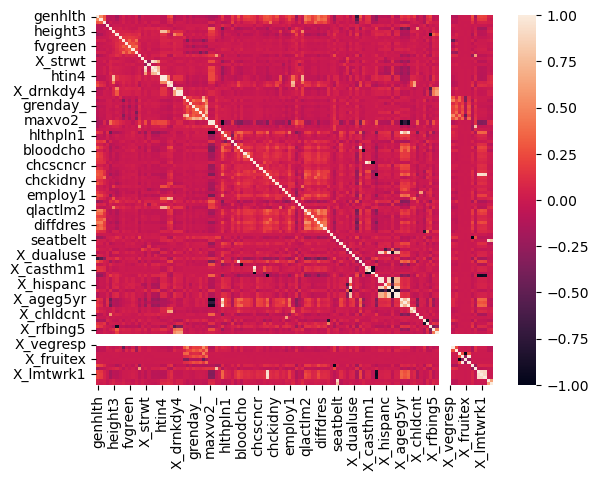

In [12]:
corr = df_pre.corr()
sns.heatmap(corr)

In [13]:
#corr[corr['genhlth']>0.2]

In [14]:
cor_matrix = df_pre.corr().abs()
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.99)]
#data_num = data_num.drop(to_drop, axis=1)
#has not drop yet

/var/folders/tc/hjg8dsq54vzfrk5v6v96k32r0000gn/T/ipykernel_7356/1444341423.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))


In [15]:
def remove_outliers(df,columns,n_std):
    for col in columns:

        mean = df[col].mean()
        sd = df[col].std()
        
        df = df[(df[col] <= mean+(n_std*sd))]
        
    return df

#remove the outliers, set to 7*std
df_pre_remove_outliers = remove_outliers(df_pre,df_pre.columns,7)
df_pre_remove_outliers.shape

(329831, 124)

In [16]:
df_try1 = df_pre_remove_outliers.drop(columns=['X_misfrtn','X_misvegn','X_frtresp','X_vegresp'])

In [11]:
df_try1 = df_try1[['genhlth','X_lmtwrk1','X_prace1','diffalon','employ1','diffwalk','alcday5','exerany2','chcocncr','X_frtlt1','useequip',
'X_vegesum','X_drdxar1','X_fruitex','cvdinfr4','bphigh4','X_rfbmi5','X_rfhlth','decide','X_rfsmok3','X_bmi5',
'qlactlm2','X_totinda','X_pastrng','diabete3','havarth3','physhlth','internet','medcost','menthlth','chccopd1',
'X_hispanc','X_smoker3','drocdy3_','cvdcrhd4','X_drnkmo4','grenday_','X_dualuse','addepev2','educa',
'frutda1_','sleptim1','X_rfseat3','X_rfhype5','hlthpln1','strength','X_cholchk','sex','fc60_','X_age_g','X_educag',
'persdoc2','children','cvdstrk3','chckidny','qstlang','strfreq_','htin4','wtkg3','drnkany5','X_rfbing5','flushot6',
'veteran3','X_lmtscl1','X_raceg21','X_rfseat2','X_age65yr','checkup1','beanday_','X_rawrake','seatbelt','X_ageg5yr',
'X_age80','renthom1','X_race_g1','X_racegr3','X_ststr','X_rfdrhv4','pamiss1_','marital','chcscncr']]

In [13]:
df_try1.to_csv('df_try1.csv')

In [12]:
df_try1

,genhlth,X_lmtwrk1,X_prace1,diffalon,employ1,diffwalk,alcday5,exerany2,chcocncr,X_frtlt1,...,X_ageg5yr,X_age80,renthom1,X_race_g1,X_racegr3,X_ststr,X_rfdrhv4,pamiss1_,marital,chcscncr
0,3,0,7,0,2,0,0.0,1,0,0,...,6,50.0,1,4,4,11081.0,0,0.0,2,0
1,3,1,7,0,2,1,220.0,0,0,0,...,7,55.0,1,4,4,11081.0,1,0.0,2,0
2,2,0,7,0,5,0,208.0,1,0,0,...,8,64.0,1,4,4,11081.0,0,0.0,2,0
3,3,0,7,0,5,0,210.0,0,1,0,...,9,66.0,1,4,4,11082.0,0,0.0,2,0
4,2,0,2,0,2,0,0.0,1,0,1,...,5,49.0,1,0,0,11081.0,0,0.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
329826,3,2,7,0,0,0,0.0,0,0,0,...,9,65.0,1,1,1,722019.0,0,0.0,2,0
329827,3,0,7,0,2,1,204.0,1,0,0,...,5,47.0,1,1,1,722019.0,0,0.0,2,0
329828,4,2,7,1,0,1,0.0,0,0,1,...,7,58.0,1,1,1,722019.0,0,0.0,1,0
329829,4,0,6,0,2,0,0.0,1,0,1,...,3,37.0,1,1,1,722019.0,0,0.0,0,0


The data contains 339282 rows and 124 columns (1 response variable & 123 features)
- 39 numerical columns
- 36 YES/NO columns
- 48 others

## Model

In [71]:
df_try1 = pd.read_csv('df_try1.csv', encoding= 'unicode_escape', low_memory=False, index_col=0)

In [72]:
df_try1 = df_try1[(df_try1['genhlth'] == 1)|(df_try1['genhlth'] == 3)|(df_try1['genhlth'] == 5)]

In [73]:
train_y = df_try1.iloc[:,0]
train_x = df_try1.iloc[:,1:]
X_train, X_test, Y_train, Y_test = train_test_split(train_x, train_y, random_state= 123)

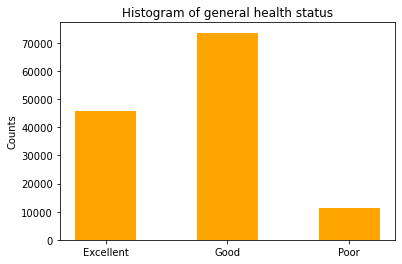

In [74]:
plt.hist(Y_train,bins=[0,2,4,6],rwidth=0.5, color = 'orange')
plt.xticks([1,3,5],['Excellent','Good','Poor'])
plt.ylabel('Counts')
plt.title('Histogram of general health status')
plt.show()

In [52]:
#Random Forest before oversampling
scaler = StandardScaler()
scaler.fit(X_train)
scaled_x_train = scaler.transform(X_train)
scaler.fit(X_test)
scaled_x_test = scaler.transform(X_test)

clf = RandomForestClassifier() 
clf.fit(scaled_x_train, Y_train)
predictions = clf.predict(scaled_x_test)
print(classification_report(Y_test,predictions))
print('The accuracy score is',accuracy_score(Y_test,predictions))

              precision    recall  f1-score   support

           1       0.75      0.65      0.69     15549
           3       0.79      0.86      0.83     24412
           5       1.00      1.00      1.00      3698

    accuracy                           0.80     43659
   macro avg       0.85      0.84      0.84     43659
weighted avg       0.79      0.80      0.79     43659

The accuracy score is 0.7970636065874162


In [50]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_train_over, Y_train_over = sm.fit_resample(X_train, Y_train)
#x_train, x_test, y_train, y_test = train_test_split(X_res, Y_res, random_state= 123)

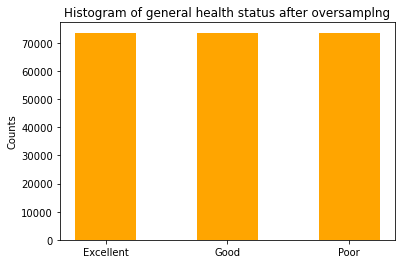

In [51]:
plt.hist(Y_train_over,bins=[0,2,4,6],rwidth=0.5, color = 'orange')
plt.xticks([1,3,5],['Excellent','Good','Poor'])
plt.ylabel('Counts')
plt.title('Histogram of general health status after oversamplng')
plt.show()

In [53]:
#Random Forest after oversampling
scaler = StandardScaler()
scaler.fit(X_train_over)
scaled_x_train = scaler.transform(X_train_over)
scaler.fit(X_test)
scaled_x_test = scaler.transform(X_test)

clf = RandomForestClassifier() 
clf.fit(scaled_x_train, Y_train_over)
predictions = clf.predict(scaled_x_test)
print(classification_report(Y_test,predictions))
print('The accuracy score is',accuracy_score(Y_test,predictions))

              precision    recall  f1-score   support

           1       0.76      0.55      0.64     15549
           3       0.76      0.89      0.82     24412
           5       1.00      1.00      1.00      3698

    accuracy                           0.78     43659
   macro avg       0.84      0.81      0.82     43659
weighted avg       0.78      0.78      0.77     43659

The accuracy score is 0.7792894935752078


In [66]:
#from imblearn.under_sampling import ClusterCentroids
#cc = ClusterCentroids()
#X_train_under, Y_train_under = cc.fit_resample(X_train,Y_train)
#train_x, test_x, train_y, test_y = train_test_split(X_res, Y_res, random_state= 123)

In [55]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_res, Y_res = sm.fit_resample(train_x, train_y)
#x_train, x_test, y_train, y_test = train_test_split(X_res, Y_res, random_state= 123)

In [56]:
#using SMOTE
scaler = StandardScaler()
scaler.fit(x_train)
scaled_x_train = scaler.transform(x_train)
scaler.fit(x_test)
scaled_x_test = scaler.transform(x_test)

clf = RandomForestClassifier() 
clf.fit(scaled_x_train, y_train)
predictions = clf.predict(scaled_x_test)
print(classification_report(y_test,predictions))
print('The accuracy score is',accuracy_score(y_test,predictions))

              precision    recall  f1-score   support

           1       0.83      0.81      0.82     24794
           3       0.81      0.83      0.82     24382
           5       1.00      1.00      1.00     24397

    accuracy                           0.88     73573
   macro avg       0.88      0.88      0.88     73573
weighted avg       0.88      0.88      0.88     73573

The accuracy score is 0.879045301945007


In [68]:
cat = [X_train.columns.get_loc(c) for c in X_train.select_dtypes(include='int64').columns if c in X_train]

In [75]:
from imblearn.over_sampling import SMOTENC
smc = SMOTENC(cat)
x_train, y_train = sm.fit_resample(X_train, Y_train)
#x_train, x_test, y_train, y_test = train_test_split(X_res, Y_res, random_state= 123)

In [76]:
#using SMOTENC
scaler = StandardScaler()
scaler.fit(x_train)
scaled_x_train = scaler.transform(x_train)
scaler.fit(X_test)
scaled_x_test = scaler.transform(X_test)

clf = RandomForestClassifier() 
clf.fit(scaled_x_train, y_train)
predictions = clf.predict(scaled_x_test)
print(classification_report(Y_test,predictions))
print('The accuracy score for SMOTENC is',accuracy_score(Y_test,predictions))

              precision    recall  f1-score   support

           1       0.77      0.55      0.64     15549
           3       0.76      0.89      0.82     24412
           5       1.00      1.00      1.00      3698

    accuracy                           0.78     43659
   macro avg       0.84      0.82      0.82     43659
weighted avg       0.78      0.78      0.77     43659

The accuracy score for SMOTENC is 0.782312925170068


In [77]:
import warnings
warnings.filterwarnings('ignore')

In [78]:
#logistic regression before oversampling
scaler = StandardScaler()
scaler.fit(X_train)
scaled_x_train = scaler.transform(X_train)
scaler.fit(X_test)
scaled_x_test = scaler.transform(X_test)

model_Log = LogisticRegression().fit(scaled_x_train, Y_train)
y_pred_Log = model_Log.predict(scaled_x_test)
print(classification_report(Y_test,y_pred_Log))
print('The accuracy score is',accuracy_score(Y_test,y_pred_Log))

              precision    recall  f1-score   support

           1       0.72      0.69      0.70     15549
           3       0.81      0.83      0.82     24412
           5       1.00      1.00      1.00      3698

    accuracy                           0.79     43659
   macro avg       0.84      0.84      0.84     43659
weighted avg       0.79      0.79      0.79     43659

The accuracy score is 0.7914519343090771


- using decision tree

In [79]:
def train_using_gini(X_train, X_test, y_train):
  
    # Creating the classifier object
    clf_gini = DecisionTreeClassifier(criterion = "gini",
            random_state = 100,max_depth=10, min_samples_leaf=10)
  
    # Performing training
    clf_gini.fit(X_train, y_train)
    return clf_gini
      
# Function to perform training with entropy.
def tarin_using_entropy(X_train, X_test, y_train):
  
    # Decision tree with entropy
    clf_entropy = DecisionTreeClassifier(
            criterion = "entropy", random_state = 100,
            max_depth = 10, min_samples_leaf = 10)
  
    # Performing training
    clf_entropy.fit(X_train, y_train)
    return clf_entropy

# Function to make predictions
def prediction(X_test, clf_object):
  
    # Predicton on test with giniIndex
    y_pred = clf_object.predict(X_test)
    print("Predicted values:")
    print(y_pred)
    return y_pred
      
# Function to calculate accuracy
def cal_accuracy(y_test, y_pred):
      
    print("Confusion Matrix: ",
        confusion_matrix(y_test, y_pred))
      
    print ("Accuracy : ",
    accuracy_score(y_test,y_pred))
      
    print("Report : ",
    classification_report(y_test, y_pred))

In [81]:
clf_gini = train_using_gini(scaled_x_train, scaled_x_test, Y_train)
y_pred_gini = prediction(scaled_x_test, clf_gini)
cal_accuracy(Y_test, y_pred_gini)

Predicted values:
[5 3 1 ... 1 1 1]
Confusion Matrix:  [[10700  4849     0]
 [ 5219 19193     0]
 [    0     0  3698]]
Accuracy :  0.7693946265374837
Report :                precision    recall  f1-score   support

           1       0.67      0.69      0.68     15549
           3       0.80      0.79      0.79     24412
           5       1.00      1.00      1.00      3698

    accuracy                           0.77     43659
   macro avg       0.82      0.82      0.82     43659
weighted avg       0.77      0.77      0.77     43659



In [82]:
clf_entropy = tarin_using_entropy(scaled_x_train, scaled_x_test, Y_train)
y_pred_entropy = prediction(scaled_x_test, clf_entropy)
cal_accuracy(Y_test, y_pred_entropy)

Predicted values:
[5 3 1 ... 1 3 1]
Confusion Matrix:  [[10093  5456     0]
 [ 4552 19860     0]
 [    0     0  3698]]
Accuracy :  0.7707689136260565
Report :                precision    recall  f1-score   support

           1       0.69      0.65      0.67     15549
           3       0.78      0.81      0.80     24412
           5       1.00      1.00      1.00      3698

    accuracy                           0.77     43659
   macro avg       0.82      0.82      0.82     43659
weighted avg       0.77      0.77      0.77     43659



In [ ]:
#clf = GradientBoostingClassifier() # n_estimators=200, max_depth = 5, random_state = 42
#clf.fit(x_train, y_train)
#predictions = clf.predict(x_test)
#print(classification_report(y_test,predictions))
#print('The accuracy score is',accuracy_score(y_test,predictions))

In [83]:
scaler = StandardScaler()
scaler.fit(X_train)
scaled_x_train = scaler.transform(X_train)
scaler.fit(X_test)
scaled_x_test = scaler.transform(X_test)

clf = GradientBoostingClassifier() # n_estimators=1000, max_depth = 5, random_state = 42
clf.fit(scaled_x_train, Y_train)
predictions = clf.predict(scaled_x_test)
print(classification_report(Y_test,predictions))
print('The accuracy score is',accuracy_score(Y_test,predictions))

              precision    recall  f1-score   support

           1       0.74      0.67      0.70     15549
           3       0.80      0.85      0.83     24412
           5       1.00      1.00      1.00      3698

    accuracy                           0.80     43659
   macro avg       0.85      0.84      0.84     43659
weighted avg       0.80      0.80      0.80     43659

The accuracy score is 0.7986669415240844


In [85]:
scaler = StandardScaler()
scaler.fit(X_train)
scaled_x_train = scaler.transform(X_train)
scaler.fit(X_test)
scaled_x_test = scaler.transform(X_test)

clf = GradientBoostingClassifier(max_depth = 5) # n_estimators=1000, max_depth = 5, random_state = 42
clf.fit(scaled_x_train, Y_train)
predictions = clf.predict(scaled_x_test)
print(classification_report(Y_test,predictions))
print('The accuracy score is',accuracy_score(Y_test,predictions))

              precision    recall  f1-score   support

           1       0.74      0.68      0.71     15549
           3       0.81      0.85      0.83     24412
           5       1.00      1.00      1.00      3698

    accuracy                           0.80     43659
   macro avg       0.85      0.84      0.85     43659
weighted avg       0.80      0.80      0.80     43659

The accuracy score is 0.8010948487138964


In [86]:
scaler = StandardScaler()
scaler.fit(X_train)
scaled_x_train = scaler.transform(X_train)
scaler.fit(X_test)
scaled_x_test = scaler.transform(X_test)

clf = GradientBoostingClassifier(n_estimators=200, max_depth = 5) # n_estimators=1000, max_depth = 5, random_state = 42
clf.fit(scaled_x_train, Y_train)
predictions = clf.predict(scaled_x_test)
print(classification_report(Y_test,predictions))
print('The accuracy score is',accuracy_score(Y_test,predictions))

              precision    recall  f1-score   support

           1       0.74      0.68      0.71     15549
           3       0.81      0.85      0.83     24412
           5       1.00      1.00      1.00      3698

    accuracy                           0.80     43659
   macro avg       0.85      0.84      0.85     43659
weighted avg       0.80      0.80      0.80     43659

The accuracy score is 0.8019652305366591


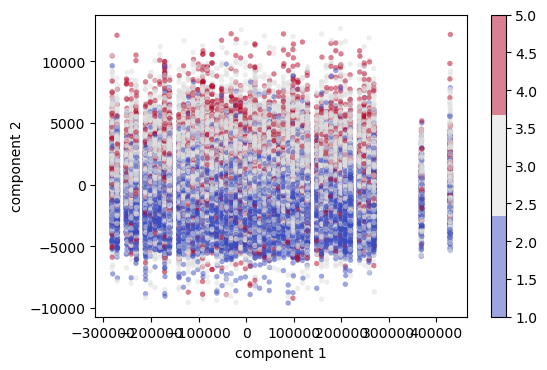

In [65]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
pca_sklearn = PCA()
projected = pca_sklearn.fit_transform(train_x)

figure = plt.figure(dpi=100)
plt.scatter(projected[:, 0], projected[:, 1],c=train_y, s=15, edgecolor='none', alpha=0.5,cmap=plt.cm.get_cmap('coolwarm', 3))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar()
plt.show()

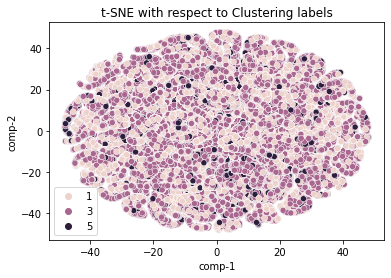

In [84]:
from sklearn.manifold import TSNE
import seaborn as sns
tsne = TSNE(n_components=2, random_state=123)
z = tsne.fit_transform(train_x) 

df = pd.DataFrame()
df["y"] = train_y
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]

sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                data=df).set(title="t-SNE with respect to Clustering labels")
plt.show()

In [133]:
#from mpl_toolkits.mplot3d import Axes3D

In [132]:
# Visualize data with true label
#pca_sklearn = PCA(n_components=3)
#PC = pca_sklearn.fit_transform(train_x)
#df_pc = pd.DataFrame(data=PC[:, :3], columns=['PC1', 'PC2', 'PC3'])
#df_pc['genlth'] = train_y

#fig = plt.figure()
#ax = Axes3D(fig, elev=25, azim=50)
#ax.scatter(df_pc['PC1'], df_pc['PC2'], df_pc['PC3'], c=df_pc['genlth'])
#ax.set_xlabel('Principal component 1')
#ax.set_ylabel('Principal component 2')
#ax.set_zlabel('Principal component 3');

In [131]:
#import plotly.express as px
#from sklearn.decomposition import PCA

#pca = PCA(n_components=3)
#components = pca.fit_transform(train_x)

#total_var = pca.explained_variance_ratio_.sum() * 100

#fig = px.scatter_3d(
#    components, x=0, y=1, z=2, color=train_y,size_max=1
#)
#fig.show()

In [87]:
from sklearn.model_selection import validation_curve
param_range = np.arange(1, 250, 2)

train_scores, test_scores = validation_curve(RandomForestClassifier(),
                                  train_x, train_y, param_name="n_estimators", param_range=param_range,
                                  cv=4, scoring="accuracy", n_jobs=-1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

KeyboardInterrupt: 

In [ ]:
plt.subplots(1, figsize=(7,7))
plt.plot(param_range, train_mean, label="Training score", color="black")
plt.plot(param_range, test_mean, label="Cross-validation score", color="dimgrey")

plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color="gray")
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, color="gainsboro")
 
plt.title("Validation Curve With Random Forest")
plt.xlabel("Number Of Trees")
plt.ylabel("Accuracy Score")
plt.tight_layout()
plt.legend(loc="best")
plt.show()

In [103]:
df_try1 = pd.read_csv('df_try1.csv', encoding= 'unicode_escape', low_memory=False, index_col=0)

In [104]:
train_y = df_try1.iloc[:,0]
train_x = df_try1.iloc[:,1:]
X_train, X_test, Y_train, Y_test = train_test_split(train_x, train_y, random_state= 123)

In [105]:
Y_train = Y_train-1

In [106]:
from sklearn.utils import class_weight
from xgboost import XGBClassifier

class_weight = class_weight.compute_class_weight('balanced', classes=np.unique(Y_train), y=Y_train)

def BalancedSampleWeights(y_train,class_weight_coef):
    classes = np.unique(y_train, axis = 0)
    classes.sort()
    class_samples = np.bincount(y_train)
    total_samples = class_samples.sum()
    n_classes = len(class_samples)
    weights = total_samples / (n_classes * class_samples * 1.0)
    class_weight_dict = {key : value for (key, value) in              
                        zip(classes, weights)}
    class_weight_dict[classes[1]] = class_weight_dict[classes[1]] *  class_weight_coef
    sample_weights = [class_weight_dict[i] for i in y_train]
    return sample_weights

weight=BalancedSampleWeights(Y_train,class_weight)
model = XGBClassifier(booster='gblinear',sample_weight = weight)
model.fit(X_train, Y_train)
predictions = model.predict(X_test)
print(classification_report(Y_test-1,predictions))
print('The accuracy score is',accuracy_score(Y_test-1,predictions))

[16:21:49] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "sample_weight" } are not used.

              precision    recall  f1-score   support

           0       0.52      0.26      0.35     15311
           1       0.50      0.69      0.58     29300
           2       0.62      0.53      0.57     24341
           3       0.83      0.89      0.86      9848
           4       0.64      0.52      0.57      3658

    accuracy                           0.58     82458
   macro avg       0.62      0.58      0.59     82458
weighted avg       0.58      0.58      0.57     82458

The accuracy score is 0.5783914235125761
